# Multilayer Perceptrons for Multiclass Classification (Exercise)

## The Data

We will be using the Glass Identification dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/):

https://archive.ics.uci.edu/ml/datasets/Glass+Identification

**Information**

From USA Forensic Science Service, 5 types of glass defined in terms of their oxide content (i.e. Na, Fe, K, etc).
The study of classification of types of glass was motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence... if it is correctly identified!

**Attributes**

1. RI: refractive index
2. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
3. Mg: Magnesium
4. Al: Aluminum
5. Si: Silicon
6. K: Potassium
7. Ca: Calcium
8. Ba: Barium
9. Fe: Iron
10. Type of glass: (class attribute)
    - 1. building windows
    - 2. vehicle windows
    - 3. containers
    - 4. tableware
    - 5. headlamps

## Table of Contents
- ### [Python libraries](#libraries)
- ### [Data Exploration and Feature Engineering](#exploration)
    - #### [Read the data](#read)
    - #### [Descriptive statistics](#statistics)
    - #### [Class balance](#balance)
    - #### [Correlations](#correlation)
    - #### [Remove outliers](#outliers)
- ### [Label and One-Hot encoding](#one-hot)
    - #### [Create the `X` and `y` variables](#variables)
    - #### [Encode target labels](#encoders)
- ### [Split the Data](#split)
- ### [Normalize the Data](#normalize)
- ### [Create the Model](#model)
- ### [Train the Model](#training)
    - #### [Choosing too many epochs and overfit](#overfit)
    - #### [Early Stopping](#early_stop)
- ### [Evaluate the Model](#evaluation)
- ### [Predictions](#predictions)

<a id='libraries'></a>
## Python libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<a id='exploration'></a>
## Data Exploration and Feature Engineering

<a id='read'></a>
### Read the data

In [3]:
df = pd.read_csv('../../Data/glass.csv').drop(columns='Unnamed: 0')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,building_windows
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,building_windows
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,building_windows
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,building_windows
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,building_windows


In [6]:
glass_types = {"building_windows": 1,
 "vehicle_windows": 2,
 "containers": 3,
 "tableware": 4,
 "headlamps": 5}

df['glass_type_id'] = df['glass_type'].apply(lambda x: glass_types[x]) 

df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type,glass_type_id
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,building_windows,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,building_windows,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,building_windows,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,building_windows,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,building_windows,1


<a id='statistics'></a>
### Descriptive statistics

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RI,214.0,1.518365,0.003037,1.51115,1.516523,1.51768,1.519157,1.53393
Na,214.0,13.407850,0.816604,10.73000,12.907500,13.30000,13.825000,17.38000
Mg,214.0,2.684533,1.442408,0.00000,2.115000,3.48000,3.600000,4.49000
Al,214.0,1.444907,0.499270,0.29000,1.190000,1.36000,1.630000,3.50000
Si,214.0,72.650935,0.774546,69.81000,72.280000,72.79000,73.087500,75.41000
K,214.0,0.497056,0.652192,0.00000,0.122500,0.55500,0.610000,6.21000
Ca,214.0,8.956963,1.423153,5.43000,8.240000,8.60000,9.172500,16.19000
Ba,214.0,0.175047,0.497219,0.00000,0.000000,0.00000,0.000000,3.15000
Fe,214.0,0.057009,0.097439,0.00000,0.000000,0.00000,0.100000,0.51000
glass_type_id,214.0,1.869159,1.457273,1.00000,1.000000,1.00000,2.000000,5.00000


<a id='balance'></a>
### Class balance

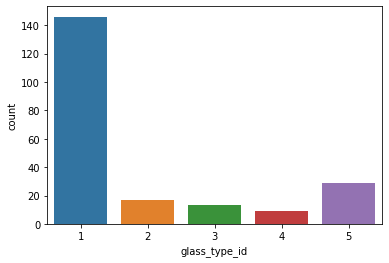

In [8]:
sns.countplot(x='glass_type_id',data=df)

<a id='correlation'></a>
### Correlations

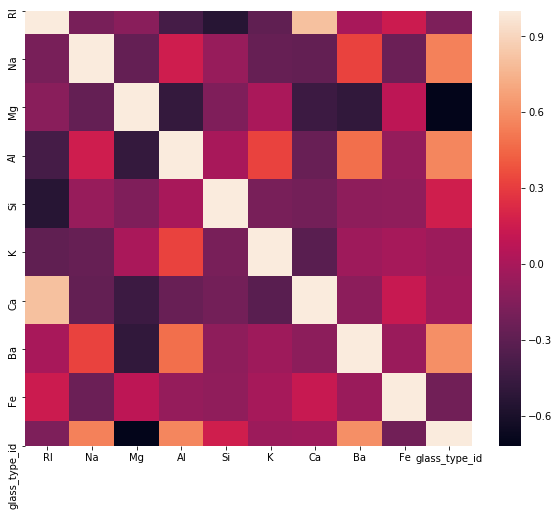

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr())

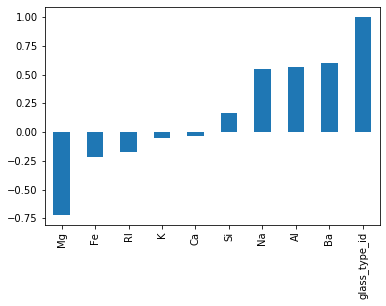

In [11]:
df.corr()['glass_type_id'].sort_values().plot(kind='bar')

<a id='outliers'></a>
### Remove outliers

Seaborn uses [inter-quartile range](https://en.wikipedia.org/wiki/Interquartile_range) to detect the outliers. What we need to do is to reproduce the same function in the column you want to drop the outliers. We can do that by using the next function.

In [13]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 
    
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 *IQR)
    
    return df.loc[filter]

#### Refractive index

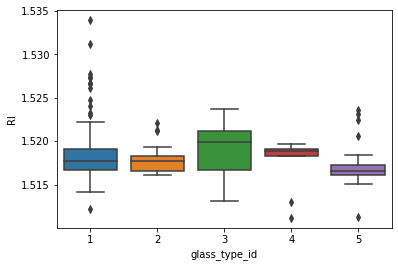

In [14]:
sns.boxplot(x='glass_type_id', y='RI', data=df)

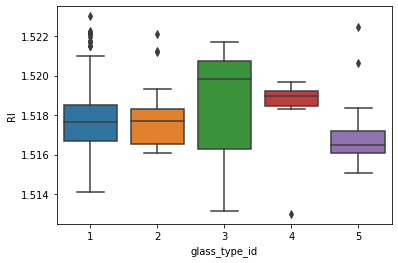

In [15]:
df = remove_outliers(df, 'RI')
sns.boxplot(x='glass_type_id', y='RI', data=df)

#### Potassium

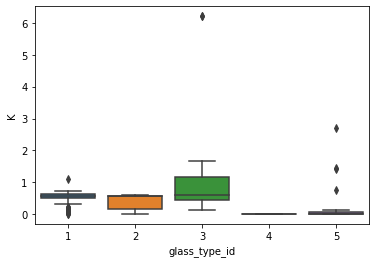

In [16]:
sns.boxplot(x='glass_type_id', y='K', data=df)

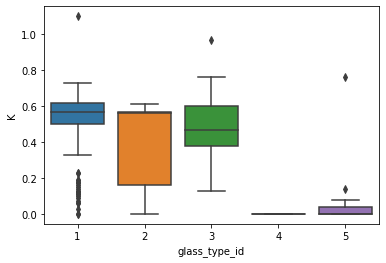

In [17]:
df = remove_outliers(df, 'K')
sns.boxplot(x='glass_type_id', y='K', data=df)

<a id='one-hot'></a>
## Label and One-Hot encoding
For multiclass classification we have to represent categorical data in the form of binary vectors.

<a id='variables'></a>
### Create the `X` and `y` variables

In [19]:
X = df.drop(columns=['glass_type', 'glass_type_id'],axis=1).values
y = df['glass_type'].values

In [20]:
X.shape

(191, 9)

In [21]:
y.shape

(191,)

In [22]:
y[:5]

array(['building_windows', 'building_windows', 'building_windows',
       'building_windows', 'building_windows'], dtype=object)

<a id='encoders'></a>
### Encode target labels

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#### Label Encoder

In [24]:
label_encoder = LabelEncoder()
y_integer = label_encoder.fit_transform(y)

In [25]:
y_integer.shape

(191,)

In [26]:
y_integer[:5]

array([0, 0, 0, 0, 0])

#### One-Hot Encoder

In [27]:
onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = onehot_encoder.fit_transform(y_integer.reshape(len(y_integer), 1))

In [28]:
y_onehot.shape

(191, 5)

In [29]:
y_onehot[:5,:]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

<a id='split'></a>
## Split the Data

In [30]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.25, random_state=42)

In [57]:
X_train.shape

(143, 9)

In [58]:
y_train.shape

(143, 5)

<a id='normalize'></a>
## Normalize the Data

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id='model'></a>
## Create the Model

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [63]:
model = Sequential()

model.add(Dense(10,activation='relu'))
model.add(Dense(5,activation='softmax'))

# For a binary classification problem
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy']) # we can add in additional metrics https://keras.io/metrics/

<a id='training'></a>
## Train the Model

<a id='overfit'></a>
### Choosing too many epochs and overfit

In [64]:
model.fit(x=X_train, y=y_train, 
          validation_data=(X_test,y_test),
          epochs=2000)

Train on 143 samples, validate on 48 samples
Epoch 1/2000
143/143 [==============================] - 0s 2ms/sample - loss: 1.4456 - accuracy: 0.6084 - val_loss: 1.4204 - val_accuracy: 0.6042
Epoch 2/2000
143/143 [==============================] - 0s 87us/sample - loss: 1.4082 - accuracy: 0.6224 - val_loss: 1.3909 - val_accuracy: 0.6458
Epoch 3/2000
143/143 [==============================] - 0s 97us/sample - loss: 1.3726 - accuracy: 0.6434 - val_loss: 1.3636 - val_accuracy: 0.6667
Epoch 4/2000
143/143 [==============================] - 0s 131us/sample - loss: 1.3396 - accuracy: 0.6573 - val_loss: 1.3376 - val_accuracy: 0.6875
Epoch 5/2000
143/143 [==============================] - 0s 87us/sample - loss: 1.3081 - accuracy: 0.7063 - val_loss: 1.3132 - val_accuracy: 0.6875
Epoch 6/2000
143/143 [==============================] - 0s 92us/sample - loss: 1.2769 - accuracy: 0.7273 - val_loss: 1.2895 - val_accuracy: 0.6875
Epoch 7/2000
143/143 [==============================] - 0s 98us/sample - 

#### Check if the model overfits:

- **Plot loss**

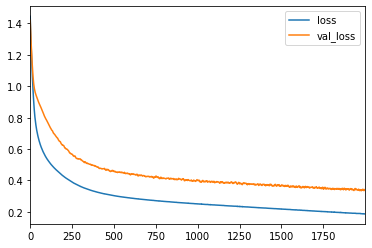

In [65]:
model_loss = pd.DataFrame(model.history.history)
model_loss[['loss', 'val_loss']].plot()

- **Plot accuracy**

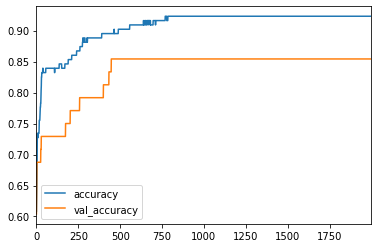

In [66]:
model_loss[['accuracy','val_accuracy']].plot()

<a id='early_stop'></a>
### Early Stopping

Let's use early stopping to track the val_loss and stop training once it begins increasing too much!

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [69]:
model = Sequential()

model.add(Dense(10,activation='relu'))
model.add(Dense(5,activation='softmax'))

# For a binary classification problem
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy']) 

In [70]:
model.fit(x=X_train, y=y_train, 
          validation_data=(X_test, y_test),
          epochs=2000,
          callbacks=[early_stop]
          )

Train on 143 samples, validate on 48 samples
Epoch 1/2000
143/143 [==============================] - 0s 2ms/sample - loss: 2.2883 - accuracy: 0.0350 - val_loss: 2.1999 - val_accuracy: 0.0625
Epoch 2/2000
143/143 [==============================] - 0s 85us/sample - loss: 2.2025 - accuracy: 0.0629 - val_loss: 2.1274 - val_accuracy: 0.0625
Epoch 3/2000
143/143 [==============================] - 0s 84us/sample - loss: 2.1205 - accuracy: 0.0909 - val_loss: 2.0555 - val_accuracy: 0.0625
Epoch 4/2000
143/143 [==============================] - 0s 84us/sample - loss: 2.0398 - accuracy: 0.1189 - val_loss: 1.9849 - val_accuracy: 0.0833
Epoch 5/2000
143/143 [==============================] - 0s 81us/sample - loss: 1.9598 - accuracy: 0.1329 - val_loss: 1.9164 - val_accuracy: 0.0625
Epoch 6/2000
143/143 [==============================] - 0s 122us/sample - loss: 1.8835 - accuracy: 0.1329 - val_loss: 1.8505 - val_accuracy: 0.0417
Epoch 7/2000
143/143 [==============================] - 0s 85us/sample - 

- **Plot loss**

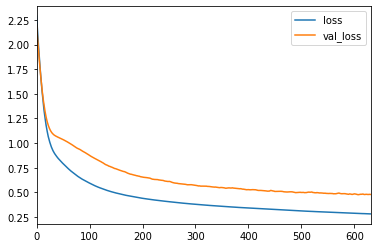

In [71]:
model_loss = pd.DataFrame(model.history.history)
model_loss[['loss', 'val_loss']].plot()

- **Plot accuracy**

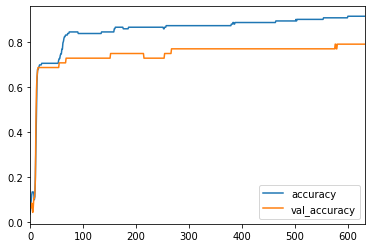

In [72]:
model_loss[['accuracy','val_accuracy']].plot()

**Save the model**

In [ ]:
#model.save('multiclass_classification_model.h5')

**Load the model**

In [ ]:
#model = load_model('multiclass_classification_model.h5')

<a id='evaluation'></a>
## Evaluate the Model
Check common classification metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

In [74]:
predictions = model.predict_classes(X_test)

**[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)**

In [75]:
print(classification_report(onehot_encoder.inverse_transform(y_test),predictions))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88        33
           1       0.75      0.75      0.75         4
           2       0.67      1.00      0.80         2
           3       1.00      0.33      0.50         3
           4       0.00      0.00      0.00         6

    accuracy                           0.79        48
   macro avg       0.64      0.61      0.59        48
weighted avg       0.70      0.79      0.73        48



/Users/ikersanchez/anaconda3/envs/py37tf2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**[Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)**

In [76]:
print(confusion_matrix(onehot_encoder.inverse_transform(y_test),predictions))

[[32  1  0  0  0]
 [ 1  3  0  0  0]
 [ 0  0  2  0  0]
 [ 1  0  1  1  0]
 [ 6  0  0  0  0]]


<a id='predictions'></a>
## Predictions

In [77]:
single_glass = df.drop(columns=['glass_type', 'glass_type_id'],axis=1).iloc[-1]
print("True glass type:", df['glass_type'].iloc[-1])

True glass type: headlamps


In [78]:
single_glass = scaler.transform(single_glass.values.reshape(-1, 9))

In [79]:
predicted_glass = model.predict_classes(single_glass)

In [80]:
print("Predicted glass type:", label_encoder.inverse_transform(predicted_glass)[0])

Predicted glass type: headlamps
